In [1]:
import torch
import numpy as np
import libsvmdata
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
font =  {
            'family': 'DejaVu Sans',
            'weight': 'normal',
            'size'  :  14
        }

matplotlib.rc('font', **font)
%config InlineBackend.figure_formats = ['svg']

In [2]:
X, y = libsvmdata.fetch_libsvm('a1a')
X = torch.Tensor(X.todense())
y = torch.Tensor(y)

In [3]:
from decentralized.topologies import Topologies
from oracles.binary_svc_oracle import BinarySVC
from methods.centralized_gd import CentralizedGradientDescent
from methods.decentralized_gd import DecentralizedGradientDescent
from methods.ZOSADOM import ZOSADOM
from methods.proxnsadom import PROXNSADOM
from methods.decentralized_cs import DecentralizedCommunicationSliding

In [4]:
import pickle

def get_oracles(X, y, n, grad_type):
    result = []
    start = 0
    step = X.shape[0] // n
    for tmp in range(n):
        result.append(BinarySVC(X[start:start + step], y[start:start + step], grad_type=grad_type))
        start += step
    return result


def to_list_of_loss(logs, name=None):
    result = []
    for el in logs:
        result.append(el["loss"])
    if name is not None:
        with open(name + '.pkl', 'wb') as f:
            pickle.dump(result, f)
    return np.array(result)

In [5]:
max_iter = 500
topology = "star"
n_nodes = 50

In [6]:
%%time
optimizer = CentralizedGradientDescent(
    get_oracles(X, y, n_nodes, "grad"),
    Topologies(n_nodes, topology, "gossip-laplacian", n_graphs=30),
    0.01,
    max_iter
)
optimizer.run(log=True)
cgd_loss = np.min(to_list_of_loss(optimizer.logs, name=f'smv_cgd_{topology}_{n_nodes}'))

CPU times: user 6.57 s, sys: 4.66 s, total: 11.2 s
Wall time: 8.33 s


In [7]:
%%time
optimizer = DecentralizedCommunicationSliding(
    get_oracles(X, y, n_nodes, "grad"),
    Topologies(n_nodes, topology, "gossip-laplacian", n_graphs=30),
    max_iter
)
optimizer.run(log=True)
dcs_loss = to_list_of_loss(optimizer.logs, name=f'svm_dcs_{topology}_{n_nodes}')

CPU times: user 9min 27s, sys: 4min 21s, total: 13min 49s
Wall time: 10min 25s


In [8]:
%%time
optimizer = DecentralizedGradientDescent(
    get_oracles(X, y, n_nodes, "grad"),
    Topologies(n_nodes, topology, "mixing-laplacian",  n_graphs=30),
    0.1,
    max_iter
)
optimizer.run(log=True)
dgd_loss = to_list_of_loss(optimizer.logs, name=f'smv_DGD_{topology}_{n_nodes}')

CPU times: user 6.45 s, sys: 4.5 s, total: 11 s
Wall time: 7.43 s


In [9]:
%%time
topologies = Topologies(n_nodes, topology, "gossip-laplacian",  n_graphs=30)
optimizer = ZOSADOM(
        oracles=get_oracles(X,y , n_nodes, "grad"),
        topology=topologies,
        max_iter=max_iter,
    )

optimizer.run(log=True)
zosadom_loss = to_list_of_loss(optimizer.logs, name=f'svm_zosadom_{topology}_{n_nodes}')

CPU times: user 7.98 s, sys: 5.07 s, total: 13 s
Wall time: 9.01 s


In [10]:
%%time
topologies = Topologies(n_nodes, topology, "gossip-laplacian",  n_graphs=30)
reg = 0.1
chi = topologies.chi

optimizer = PROXNSADOM(
        oracles=get_oracles(X,y , n_nodes, "grad"),
        topology=topologies,
        max_iter=max_iter,
        eta=1 / (64 * reg * chi ** 2),
        theta=reg / (16 * chi ** 2),
        r=reg,
        gamma=reg / 2,
        saddle_lr=1e-4
    )

optimizer.run(log=True, disable_tqdm=False)
proxnsadom_loss = to_list_of_loss(optimizer.logs, name=f'svm_proxnsadom_{topology}_{n_nodes}')


  0%|          | 0/500 [00:00<?, ?it/s]

inner problem gradient: norm 0.000001, max 0.000096
xnorm_diff tensor(0.0014) ynorm_diff tensor(0.0003)
consensus:  tensor(3.8268e-05)
{'loss': 1.7493360567092895, 'losses': [1.7391985654830933, 1.7560843229293823, 1.7616974115371704, 1.7504748106002808, 1.7420103549957275, 1.7560944557189941, 1.7391901016235352, 1.750491738319397, 1.756101131439209, 1.7617456912994385, 1.7420058250427246, 1.750436782836914, 1.7504667043685913, 1.744828224182129, 1.7448530197143555, 1.7476344108581543, 1.753259539604187, 1.7448269128799438, 1.7616918087005615, 1.7420068979263306, 1.753284215927124, 1.750471830368042, 1.7589290142059326, 1.7279242277145386, 1.750489354133606, 1.7476412057876587, 1.7617311477661133, 1.7504582405090332, 1.7561076879501343, 1.750454068183899, 1.7561042308807373, 1.7504794597625732, 1.7504695653915405, 1.7476327419281006, 1.7589075565338135, 1.7335705757141113, 1.7476751804351807, 1.733555555343628, 1.741989254951477, 1.7533077001571655, 1.739219307899475, 1.744837641716003

In [11]:
f_star = min(map(np.min, [dcs_loss,dgd_loss, zosadom_loss, proxnsadom_loss]))
f_star

1.0158739471435547

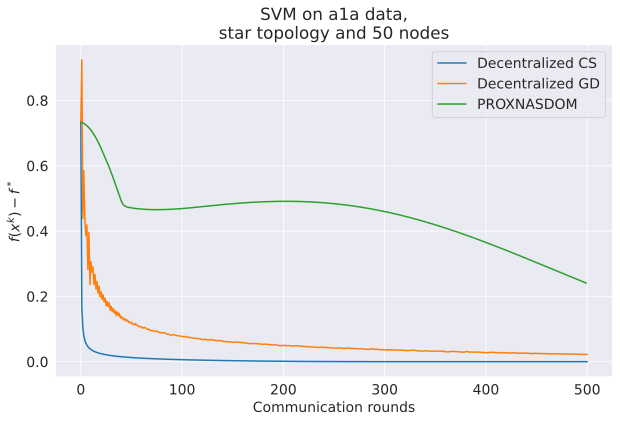

In [12]:
plt.figure(figsize=(10,6)) 
# plt.yscale("log")
plt.plot(np.arange(max_iter + 1), dcs_loss - f_star, label="Decentralized CS")
plt.plot(np.arange(max_iter + 1), dgd_loss - f_star, label="Decentralized GD")
# plt.plot(np.arange(max_iter + 1), zosadom_loss - f_star, label="ZOSADOM")
plt.plot(np.arange(max_iter), proxnsadom_loss - f_star, label="PROXNASDOM")
plt.title(r"SVM on a1a data," + f"\n{topology} topology and {n_nodes} nodes")
plt.xlabel("Communication rounds")
plt.ylabel(r"$f(x^k) - f^*$")
plt.legend()


plt.savefig(f"img/smv_a1a_{topology}_{n_nodes}.svg")